In [11]:
from dataclasses import dataclass

from project.post_processing import Plotter
from project.gen_data import gen_data
from project.timer import Timer
from project.metric import *

from heat_pinn import PinnConstParam, solve_analytical_and_numerical, \
predict_and_output_report, plot_analytical_and_numerical

@dataclass
class MLPParam:
    activation = 'relu'
    hidden_layer_sizes = (150, 200, 150, 150)

    def __str__(self) -> str:
        rs = "MLP Param: \n"
        rs =  rs + "activation: {}\n".format(self.activation)
        rs =  rs + "hidden_layer_sizes: {}\n".format(self.hidden_layer_sizes)
        return rs

def create_data_and_model(const_params: PinnConstParam, mlp_params:MLPParam, t_data_cutoff = 1.0):
    data_dict = {
        "x_range": (0, const_params.L),
        "t_range": (0, float(const_params.t_end * t_data_cutoff)),
        "x_dim": const_params.test_x_dim,
        "t_dim": int(const_params.test_t_dim * t_data_cutoff),
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }
    X_train, y_train = gen_data("heat_1d_boundary_sin_exact", data_dict)
    regr = MLPRegressor(hidden_layer_sizes = mlp_params.hidden_layer_sizes, activation=mlp_params.activation)
    return X_train, y_train, regr

def train_mlp(regr, X_train, y_train):
    # Train
    ti = Timer()
    ti.start()
    regr.fit(X_train, y_train)
    ti.stop()
    print("Training time: "+ ti.str_elapsed_time())

def predict_and_output_report_mlp(model, const_params: PinnConstParam, mlp_param: MLPParam):
    predict_and_output_report(const_params, model)
    print(mlp_param)


heat_1d_boundary_sin_exact: Average time with 25 tries: 0.0003 seconds
finite_difference_crank_nicolson: Average time with 25 tries: 0.0070 seconds


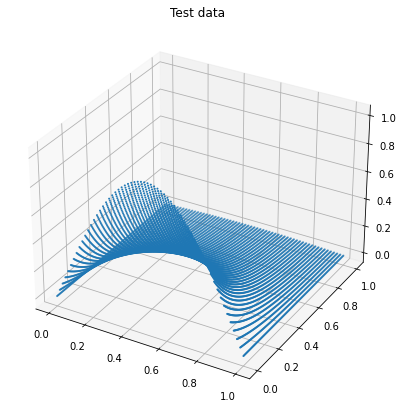

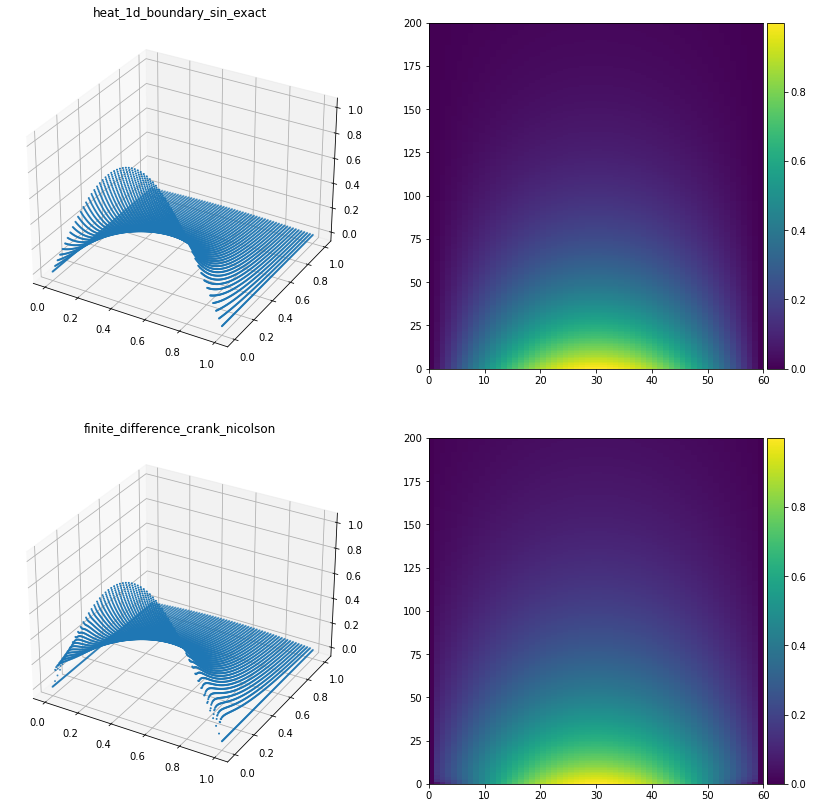

In [14]:
# Generate const test data
const_params = PinnConstParam()
solve_analytical_and_numerical(const_params)

Plotter(1,1).plot_2d_y(const_params.X_test, const_params.y_analytical, "Test data")
plot_analytical_and_numerical(Plotter(2,2), const_params)


## If I only have the early time points of my solution, can the NN predict it?

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 0.5989 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 1.0696 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 1.4488 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 1.7508 seconds


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 2.1301 seconds
[0.20081735554428162, 0.018938564782792325, 0.00563376187610433, 0.0020006914938951368, 0.0026397499235746085]


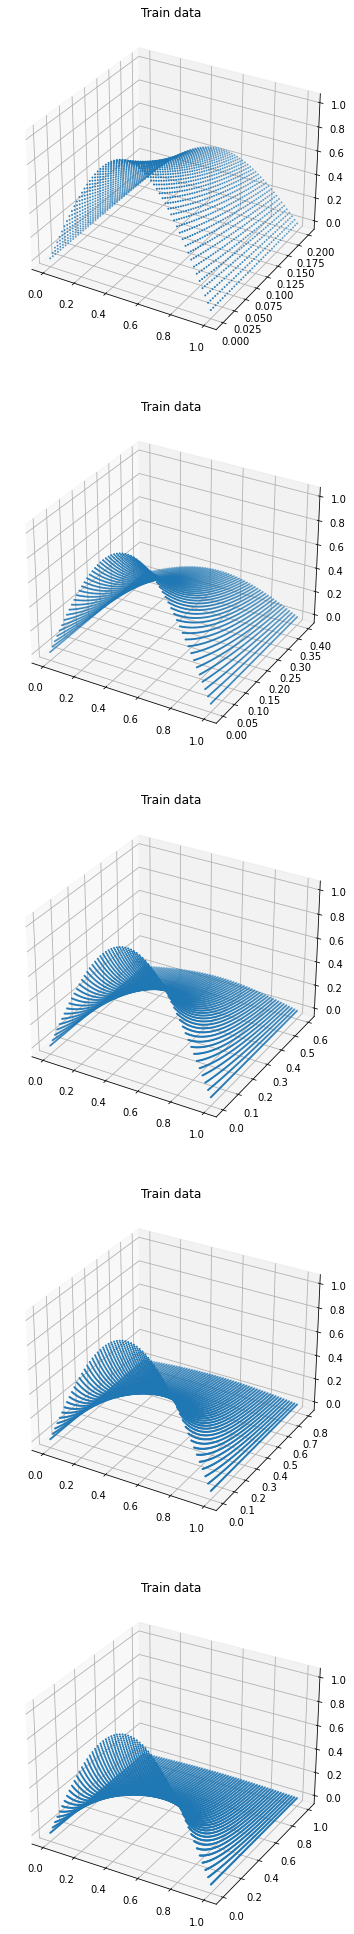

In [15]:
from sklearn.neural_network import MLPRegressor

# Make sure it divides well with test_t_dim and t_end
t_data_cutoffs = [0.2, 0.4, 0.6, 0.8, 1.0]
models = []
maes = []
mlp_params = MLPParam()

plotter = Plotter(len(t_data_cutoffs), 1)
for t_data_cutoff in t_data_cutoffs:
    X_train, y_train, regr = create_data_and_model(const_params, mlp_params, t_data_cutoff = t_data_cutoff)
    plotter.plot_2d_y(X_train, y_train, "Train data")
    train_mlp(regr, X_train, y_train)
    y_predict = regr.predict(const_params.X_test)
    mae =  compute_mean_abs_error(const_params.y_analytical, y_predict.reshape(-1,1))
    models.append(regr)
    maes.append(mae)

print(maes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-----
mae:  0.20081735554428162
t_cuttoff:  0.2
NN prediction, t_cutoff 0.2: Average time with 10 tries: 0.0502 seconds
-----
mae:  0.018938564782792325
t_cuttoff:  0.4
NN prediction, t_cutoff 0.4: Average time with 10 tries: 0.0539 seconds
-----
mae:  0.00563376187610433
t_cuttoff:  0.6
NN prediction, t_cutoff 0.6: Average time with 10 tries: 0.0490 seconds
-----
mae:  0.0020006914938951368
t_cuttoff:  0.8
NN prediction, t_cutoff 0.8: Average time with 10 tries: 0.0499 seconds
-----
mae:  0.0026397499235746085
t_cuttoff:  1.0
NN prediction, t_cutoff 1.0: Average time with 10 tries: 0.0488 seconds


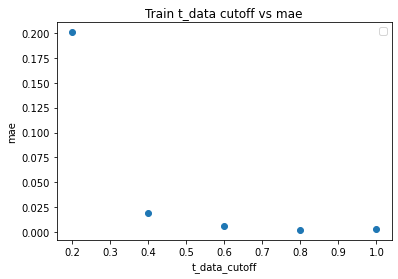

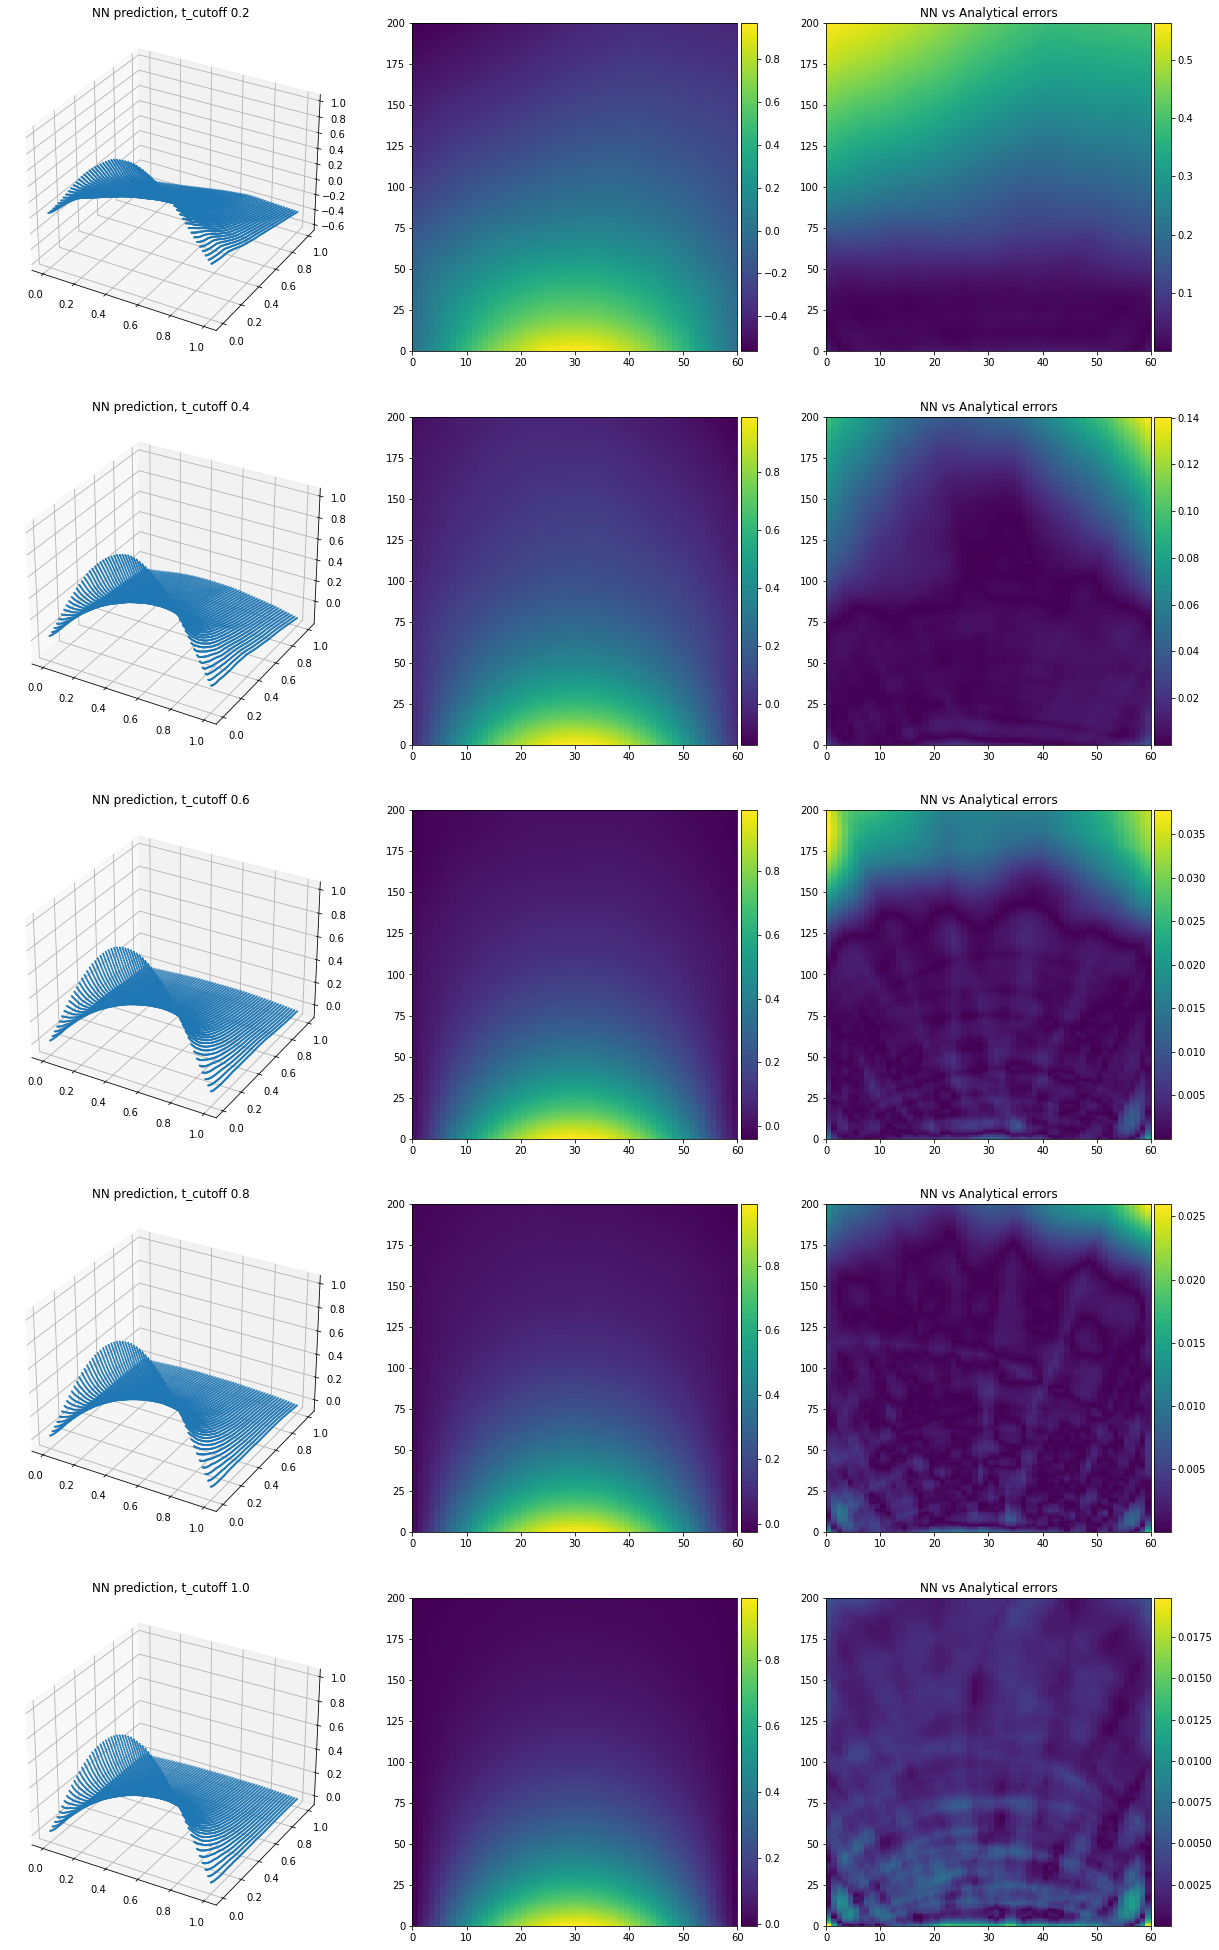

In [19]:
import matplotlib.pyplot as plt

def plot_line(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y)
    ax.legend()
    ax.set_xlabel("t_data_cutoff")
    ax.set_ylabel("mae")
    ax.title.set_text("Train t_data cutoff vs mae")

plot_line(t_data_cutoffs, maes)

plotter = Plotter(len(t_data_cutoffs), 3)
for i in range(len(models)):
    model = models[i]
    print("-----")
    t_cutoff = t_data_cutoffs[i]
    print("mae: ", maes[i])
    print("t_cuttoff: ", t_cutoff)

    # Copied
    function_name = "NN prediction, t_cutoff {}".format(t_cutoff)
    ti = Timer()
    y_pred = ti.time_average(lambda : model.predict(const_params.X_test))
    y_pred = y_pred.reshape(-1, 1)
    print(function_name + ": "+ ti.str_average())
    plotter.plot_2d_y(const_params.X_test, y_pred, function_name)
    plotter.plot_2d_colormesh(
        y_pred,
        const_params.test_x_dim,
        const_params.test_t_dim)
    #
    pinn_analytical_errors = compute_errors(const_params.y_analytical, y_pred)
    plotter.plot_2d_colormesh(
        pinn_analytical_errors,
        const_params.test_x_dim,
        const_params.test_t_dim,
        "NN vs Analytical errors")
    # Copied

In [5]:
from sklearn.model_selection import train_test_split
